contingency table:
[[3949   30]
 [1331 2572]]


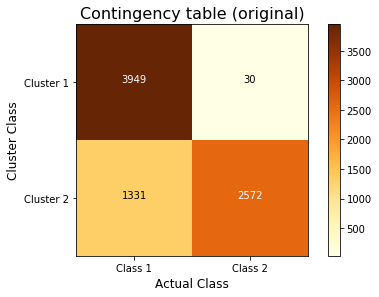


Homogeneity: 0.4243358018332555
Completeness: 0.4636994594803498
V-measure: 0.4431452004668879
Adjusted Rand Score: 0.428504440021173
Adjusted Mutual Info Score: 0.4242830978688626


In [7]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

# fetch original data
comp_tech_subclasses = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']             
rec_act_subclasses = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=comp_tech_subclasses+rec_act_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

# seperate all data into two classes
labels = [1]*len(dataset.data)
for i in range(len(dataset.data)):
    if dataset.target[i] > 3:
        labels[i] = 0

# trim data
def trim_data(data_list):
    for i in range(len(data_list)):
        temp = re.findall('[a-zA-Z]+', data_list[i])
        ans = []
        for j in range(len(temp)):
            if not temp[j].isdigit():
                ans.append(temp[j])           
        data_list[i] = " ".join(ans)
        
trim_data(dataset.data)

# generate TF-IDF matrix
vectorizer = TfidfVectorizer(min_df=3, stop_words='english', use_idf=True)
X = vectorizer.fit_transform(dataset.data)

# K-Means Clustering
km = KMeans(n_clusters=2)
km.fit(X)

# transform confusion matrix to diagonal as much as possible (only for 2 * 2 sized confusion)
def to_diagonal(confusion):
    maxColIndices = []
    copy = []
    for row in range(len(confusion)):
        curRow = confusion[row]
        index = 0
        value = curRow[0]
        ro = []
        for col in range(len(curRow)):
            ro.append(curRow[col])
            if curRow[col] > value:
                index = col
                value = curRow[col]
        maxColIndices.append(index)
        copy.append(ro)
    res = []
    for i in range(len(confusion)):
        res.insert(maxColIndices[i], copy[i])
    res = np.array(res)
    return res

# contingency table (confusion matrix)
actual_class_names = ['Class 1', 'Class 2']
cluster_class_names = ['Cluster 1', 'Cluster 2']
def plot_contingency_table(cm, title='Contingency table', cmap=plt.cm.YlOrBr):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(actual_class_names))
    plt.xticks(tick_marks, actual_class_names)
    plt.yticks(tick_marks, cluster_class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)

# Print results
confusion = metrics.confusion_matrix(labels, km.labels_)
contingency = to_diagonal(confusion)

print 'contingency table:'
print contingency
# Plot non-normalized contingency table
plt.figure()
title = 'Contingency table (original)'
plot_contingency_table(contingency, title=title)
plt.show()
print
print 'Homogeneity:', metrics.homogeneity_score(labels, km.labels_)
print 'Completeness:', metrics.completeness_score(labels, km.labels_)
print 'V-measure:', metrics.v_measure_score(labels, km.labels_)
print 'Adjusted Rand Score:', metrics.adjusted_rand_score(labels, km.labels_)
print 'Adjusted Mutual Info Score:', metrics.adjusted_mutual_info_score(labels, km.labels_)